In [ ]:
import pandas as pd 
import ast
import re
import spacy
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
nlp = spacy.load("en_core_web_sm")
from joblib import Parallel, delayed
from scipy.stats import entropy
import torch
from transformers import BertModel, BertTokenizer
import sentencepiece as spm

In [3]:
df = pd.read_csv("12-4-somethingbad.csv")
rf = df

In [3]:
def add_space_after_punctuation(text):
    pattern = r"(?<=[.,!?])(?=[^\s])"
    if pd.isnull(text):
        return text
    return re.sub(pattern, " ", text)
df['Text'] = df['Text'].apply(add_space_after_punctuation)
df['Parent Text'] = df['Parent Text'].apply(add_space_after_punctuation)

In [6]:
def process_column_to_counter(df, column_name):
    stop_words = set(stopwords.words("english"))
    texts = " ".join(df[column_name].fillna("").astype(str).tolist())
    words = texts.split()
    filtered_words = [
        word.lower() for word in words 
        if word.isalpha() and len(word) > 1 and word.lower() not in stop_words
    ]
    return Counter(filtered_words)


In [7]:
woah = dict(process_column_to_counter(df, 'Text'))

In [54]:
len(woah)

763129

In [ ]:
wee = [k for k,v in woah.items() if v > 100000]

In [58]:
lop = wee

In [8]:
wee = [k for k, v in woah.items() if 30000 <= v <= 100000]


In [76]:
len([k for k, v in woah.items() if 10000 <= v <= 100000])

457

In [145]:
woah2 = {k: v for k, v in woah.items() if v <= 100000}


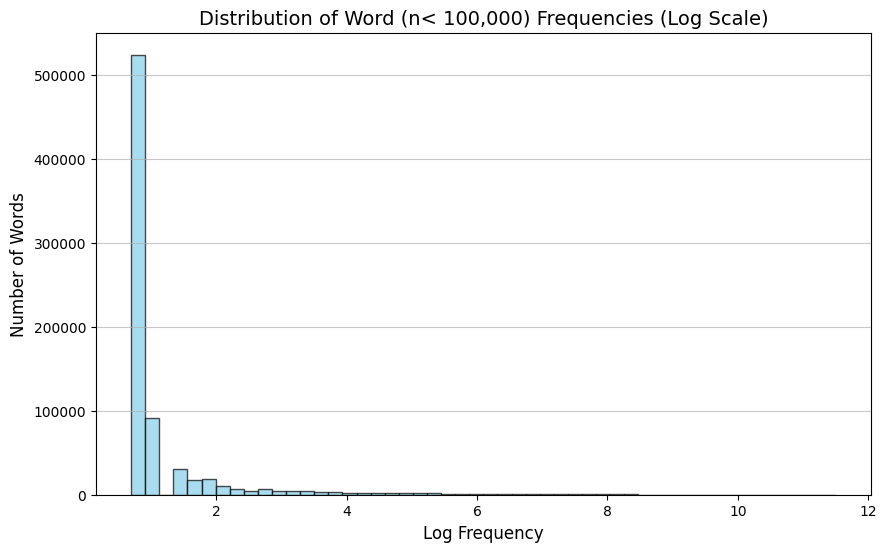

In [ ]:

frequencies = np.array(list(woah2.values()))  
log_frequencies = np.log1p(frequencies)
plt.figure(figsize=(10, 6))
plt.hist(log_frequencies, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Word (n< 100,000) Frequencies (Log Scale)', fontsize=14)
plt.xlabel('Log Frequency', fontsize=12)
plt.ylabel('Number of Words', fontsize=12)
plt.grid(axis='y', alpha=0.7)
plt.show()


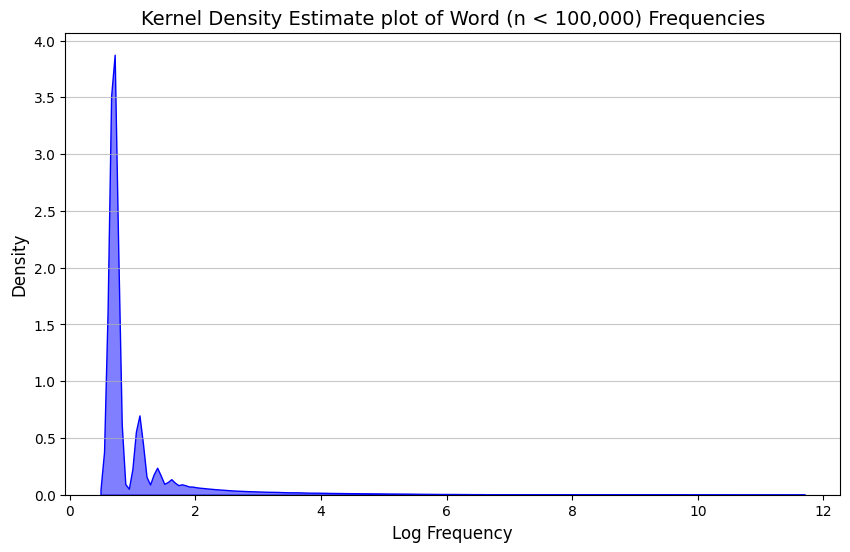

In [ ]:
frequencies = np.array(list(woah2.values()))
log_frequencies = np.log1p(frequencies)

plt.figure(figsize=(10, 6))
sns.kdeplot(log_frequencies, color='blue', fill=True, alpha=0.5)
plt.title('Kernel Density Estimate plot of Word (n < 100,000) Frequencies', fontsize=14)
plt.xlabel('Log Frequency', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(axis='y', alpha=0.7)
plt.show()


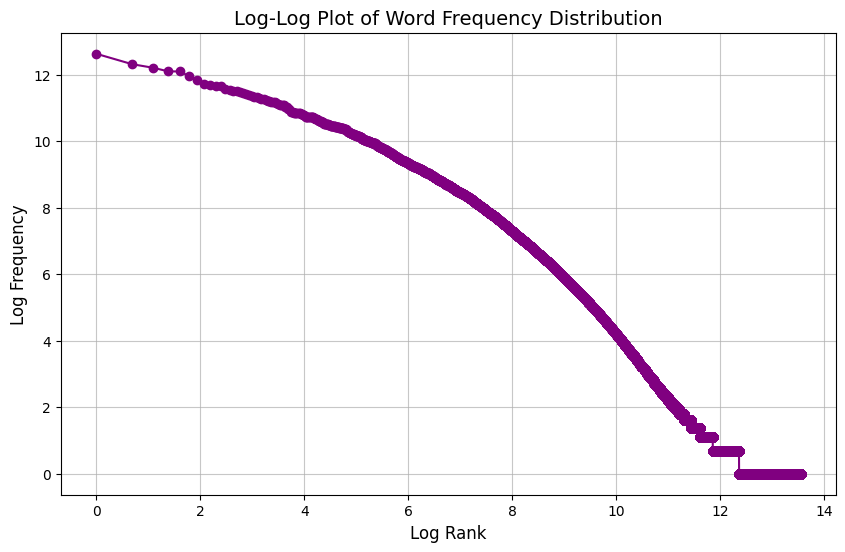

In [57]:
# Sort frequencies in descending order
sorted_frequencies = np.sort(frequencies)[::-1]
ranks = np.arange(1, len(sorted_frequencies) + 1)

# Log-transform rank and frequency
log_ranks = np.log(ranks)
log_frequencies = np.log(sorted_frequencies)

# Plot log-log distribution
plt.figure(figsize=(10, 6))
plt.plot(log_ranks, log_frequencies, marker='o', linestyle='-', color='purple')
plt.title('Log-Log Plot of Word Frequency Distribution', fontsize=14)
plt.xlabel('Log Rank', fontsize=12)
plt.ylabel('Log Frequency', fontsize=12)
plt.grid(alpha=0.7)
plt.show()


In [10]:
def get_dependency_from_doc(doc, word, return_type=False):
    if not doc:  # Handle cases where the document is None
        return None
    for token in doc:
        if token.text.lower() == word.lower():  # Match the word (case-insensitive)
            if return_type:
                return token.dep_
            else:
                return {
                    "word": token.text,
                    "coarse_pos": token.pos_,
                    "fine_pos": token.tag_,
                    "modifies": token.head.text
                }
    return None  


In [11]:
def dependencyfind(derp):
    # Combine regex filtering for all words
    regex_pattern = '|'.join(fr'\b{word}\b' for word in derp)
    filtered_df = df[
        df['Text'].str.contains(regex_pattern, na=False, regex=True) &
        df['Parent Text'].str.contains(regex_pattern, na=False, regex=True)
    ]

    # Precompute SpaCy dependency parsing
    filtered_df['Parent Dependencies'] = filtered_df['Parent Text'].apply(lambda text: nlp(text) if isinstance(text, str) else None)
    filtered_df['Text Dependencies'] = filtered_df['Text'].apply(lambda text: nlp(text) if isinstance(text, str) else None)

    # Extract dependencies for each word
    def process_word(word):
        temp_df = filtered_df.copy()
        temp_df['ParentDepend'] = temp_df['Parent Dependencies'].apply(lambda doc: get_dependency_from_doc(doc, word))
        temp_df['ParentType'] = temp_df['Parent Dependencies'].apply(lambda doc: get_dependency_from_doc(doc, word, return_type=True))
        temp_df['TextDepend'] = temp_df['Text Dependencies'].apply(lambda doc: get_dependency_from_doc(doc, word))
        temp_df['TextType'] = temp_df['Text Dependencies'].apply(lambda doc: get_dependency_from_doc(doc, word, return_type=True))
        return temp_df[['Parent Text', 'Text', 'Replied To', 'Post ID', 'ParentDepend', 'ParentType', 'TextDepend', 'TextType']]

    # Use parallel processing to handle multiple words
    merged_df = pd.concat(Parallel(n_jobs=-1)(delayed(process_word)(word) for word in derp), ignore_index=True)

    return merged_df


In [13]:
def dependencyfind(derp):
    merged_df = pd.concat([
        df[
            df['Text'].str.contains(fr'\b{word}\b', na=False, regex=True) & 
            df['Parent Text'].str.contains(fr'\b{word}\b', na=False, regex=True)
        ].assign(
            ParentDepend=lambda x: x['Parent Text'].apply(
                lambda y: find_dependency_of_word(y, word, return_type=False) if isinstance(y, str) else None
            ),
            ParentType=lambda x: x['Parent Text'].apply(
                lambda y: find_dependency_of_word(y, word, return_type=True) if isinstance(y, str) else None
            ),
            TextDepend=lambda x: x['Text'].apply(
                lambda y: find_dependency_of_word(y, word, return_type=False) if isinstance(y, str) else None
            ),
            TextType=lambda x: x['Text'].apply(
                lambda y: find_dependency_of_word(y, word, return_type=True) if isinstance(y, str) else None
            )
        )[[
            'Parent Text', 'Text', 'Replied To', 'Post ID', 
            'ParentDepend', 'ParentType', 'TextDepend', 'TextType'
        ]].reset_index(drop=True)
        for word in derp
    ], ignore_index=True)
    return merged_df


def find_dependency_of_word(text, word, return_type=False):
    doc = nlp(text)
    for token in doc:
        if token.text.lower() == word.lower():
            if return_type:
                return token.dep_
            else:
                return {
                    "word": token.text,
                    "coarse_pos": token.pos_,
                    "fine_pos": token.tag_,
                    "modifies": token.head.text
                }
    return None


In [14]:
hey = dependencyfind(wee)

In [15]:
hey.to_csv("piss.csv")

In [41]:
df = hey

In [50]:
hey['ParentWord'].nunique()

13

In [16]:
# Handle NoneType in extracting 'word' from ParentDepend and TextDepend
hey['ParentWord'] = hey['ParentDepend'].apply(lambda x: x['word'] if x and 'word' in x else None)
hey['TextWord'] = hey['TextDepend'].apply(lambda x: x['word'] if x and 'word' in x else None)

# Ensure ParentWord and TextWord are consistent and filter out rows with None
hey = hey[(hey['ParentWord'] == hey['TextWord']) & (hey['ParentWord'].notna())]

# Extract coarse and fine POS, handling NoneType cases
hey['ParentCoarsePOS'] = hey['ParentDepend'].apply(lambda x: x['coarse_pos'] if x and 'coarse_pos' in x else None)
hey['TextCoarsePOS'] = hey['TextDepend'].apply(lambda x: x['coarse_pos'] if x and 'coarse_pos' in x else None)

hey['ParentFinePOS'] = hey['ParentDepend'].apply(lambda x: x['fine_pos'] if x and 'fine_pos' in x else None)
hey['TextFinePOS'] = hey['TextDepend'].apply(lambda x: x['fine_pos'] if x and 'fine_pos' in x else None)



In [17]:
# Create transition columns for coarse and fine POS
hey['CoarseTransition'] = hey['ParentCoarsePOS'] + '→' + hey['TextCoarsePOS']
hey['FineTransition'] = hey['ParentFinePOS'] + '→' + hey['TextFinePOS']


In [24]:
hey

,Parent Text,Text,Replied To,Post ID,ParentDepend,ParentType,TextDepend,TextType,ParentWord,TextWord,ParentCoarsePOS,TextCoarsePOS,ParentFinePOS,TextFinePOS,CoarseTransition,FineTransition
0,weapons quality asideif war broke out right no...,why need a huge amount of soldiers? you think...,463811875,463812621,"{'word': 'us', 'coarse_pos': 'PRON', 'fine_pos...",nsubj,"{'word': 'us', 'coarse_pos': 'PROPN', 'fine_po...",nsubj,us,us,PRON,PROPN,PRP,NNP,PRON→PROPN,PRP→NNP
1,>i do think a combined russian missile barrage...,i've already said many times i don't consider ...,463834082,463833545,"{'word': 'us', 'coarse_pos': 'PRON', 'fine_pos...",nsubj,"{'word': 'us', 'coarse_pos': 'PRON', 'fine_pos...",compound,us,us,PRON,PRON,PRP,PRP,PRON→PRON,PRP→PRP
2,>gun control in the us is ded in the water for...,"gun for now, us gov can't impose gun contro...",463967268,463957776,"{'word': 'us', 'coarse_pos': 'PROPN', 'fine_po...",pobj,"{'word': 'us', 'coarse_pos': 'PROPN', 'fine_po...",compound,us,us,PROPN,PROPN,NNP,NNP,PROPN→PROPN,NNP→NNP
5,"no one is arguing against that, i'm just tryin...",im explain to you guys the us govt and israel...,463975982,463975677,"{'word': 'us', 'coarse_pos': 'PROPN', 'fine_po...",compound,"{'word': 'us', 'coarse_pos': 'PROPN', 'fine_po...",compound,us,us,PROPN,PROPN,NNP,NNP,PROPN→PROPN,NNP→NNP
6,>would you prefer conventional disagreement?ye...,that’s a weird way to say you agree with me.wo...,464032085,464029989,"{'word': 'us', 'coarse_pos': 'PROPN', 'fine_po...",compound,"{'word': 'us', 'coarse_pos': 'PROPN', 'fine_po...",compound,us,us,PROPN,PROPN,NNP,NNP,PROPN→PROPN,NNP→NNP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434874,>girlfriend makes heartbreaking decisiontechni...,https://www.news.com.au/lifestyle/parenting/ba...,463684780,463684531,"{'word': 'makes', 'coarse_pos': 'VERB', 'fine_...",ROOT,"{'word': 'makes', 'coarse_pos': 'VERB', 'fine_...",conj,makes,makes,VERB,VERB,VBZ,VBZ,VERB→VERB,VBZ→VBZ
434875,money doesn't make anything. it's a proxy unit...,the only jew is whoever convinced yougo show m...,463756224,463755910,"{'word': 'makes', 'coarse_pos': 'VERB', 'fine_...",ROOT,"{'word': 'makes', 'coarse_pos': 'VERB', 'fine_...",ccomp,makes,makes,VERB,VERB,VBZ,VBZ,VERB→VERB,VBZ→VBZ
434876,>i am a contrarian. this makes total sense. th...,i to go woke.this is why steam allows ce...,463756638,463755406,"{'word': 'makes', 'coarse_pos': 'VERB', 'fine_...",ROOT,"{'word': 'makes', 'coarse_pos': 'VERB', 'fine_...",ROOT,makes,makes,VERB,VERB,VBZ,VBZ,VERB→VERB,VBZ→VBZ
434877,daily reminder anti-military and 'kill your of...,what makes pedo blood cultists able to run you...,463807076,463808127,"{'word': 'makes', 'coarse_pos': 'VERB', 'fine_...",ccomp,"{'word': 'makes', 'coarse_pos': 'VERB', 'fine_...",csubj,makes,makes,VERB,VERB,VBZ,VBZ,VERB→VERB,VBZ→VBZ


In [100]:
tump = hey[hey['ParentWord']== 'trump']

In [ ]:
# Count transitions for each word
transition_counts = hey.groupby(['ParentWord', 'CoarseTransition']).size().reset_index(name='Count')

# Calculate entropy for each word
def calculate_entropy(group):
    proportions = group['Count'] / group['Count'].sum()
    return entropy(proportions)

word_entropy = transition_counts.groupby('ParentWord').apply(calculate_entropy).reset_index(name='Entropy')


/var/folders/87/9qwg67f164gck_jk0qq9fkc40000gn/T/ipykernel_69921/2231168958.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  word_entropy = transition_counts.groupby('ParentWord').apply(calculate_entropy).reset_index(name='Entropy')


In [19]:
transition_diversity = transition_counts.groupby('ParentWord')['CoarseTransition'].nunique() / \
                       transition_counts.groupby('ParentWord')['Count'].sum()
transition_diversity = transition_diversity.reset_index(name='Diversity')


In [25]:
word_entropy

,ParentWord,Entropy
0,actually,0.000000
1,already,0.000000
2,also,0.000000
3,always,0.003852
4,american,1.467714
...,...,...
105,without,0.107078
106,women,0.014202
107,work,1.408967
108,world,0.246782


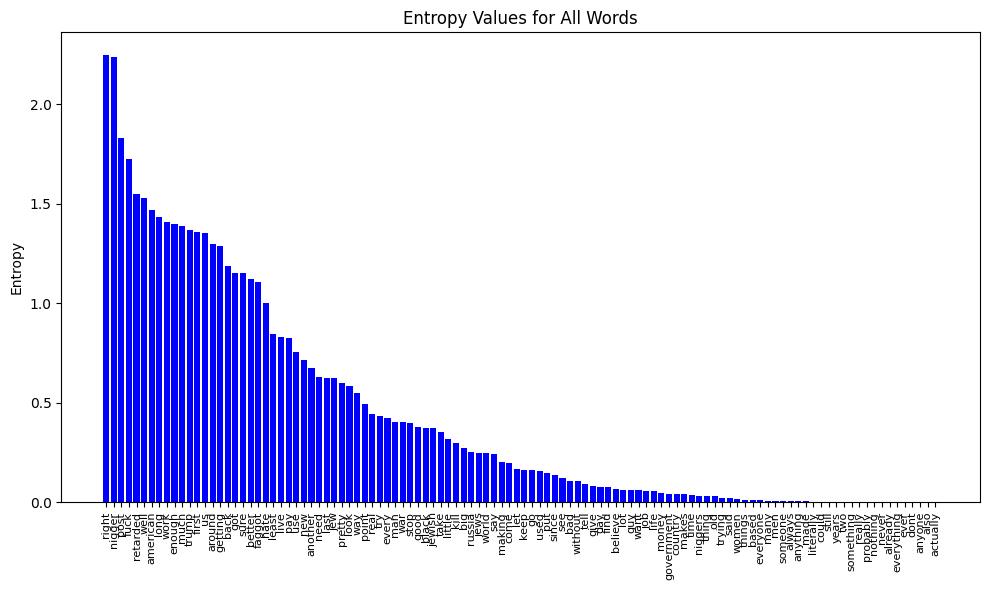

In [28]:
sorted_df = word_entropy.sort_values('Entropy', ascending=False)

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_df['ParentWord'], sorted_df['Entropy'], color='blue')
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Entropy')
plt.title('Entropy Values for All Words')
plt.tight_layout()
plt.show()

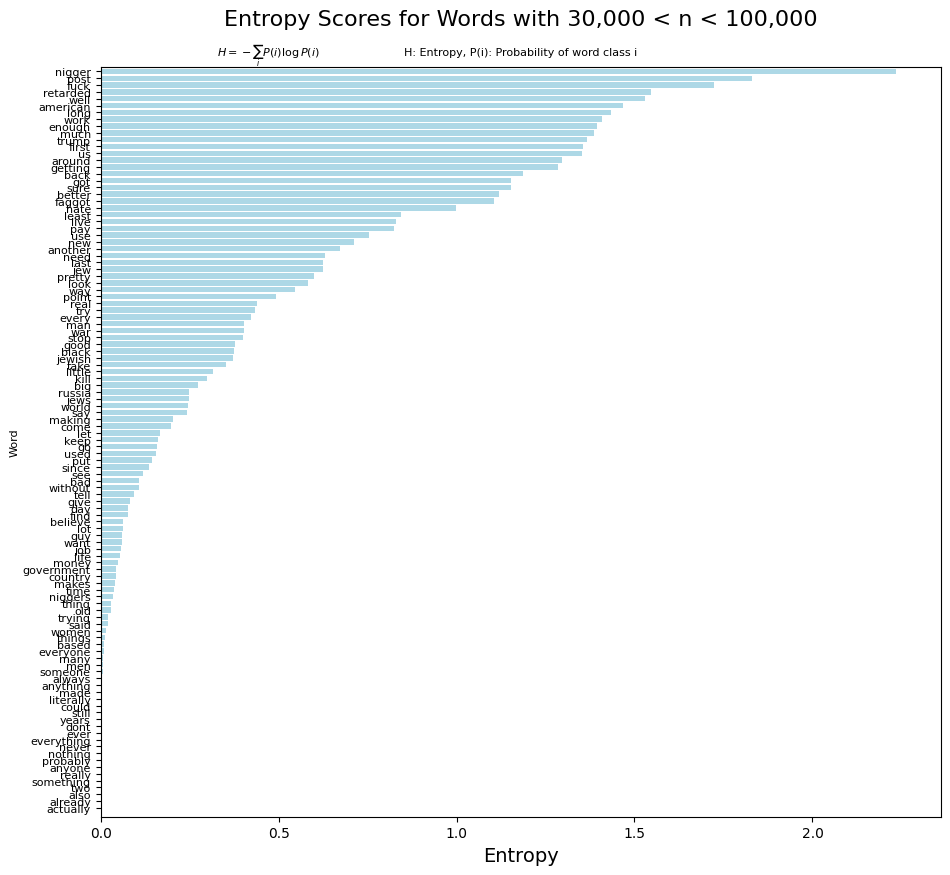

In [69]:
sorted_df = word_entropy.sort_values('Entropy', ascending=True)

# Dynamically adjust figure size based on the number of bars
num_bars = len(sorted_df)
plt.figure(figsize=(12, 10))  # Fixed height for compactness

# Adjust bar positions to reduce spacing
y_positions = [i + 0.8 for i in range(num_bars)]

# Create horizontal bar plot
plt.barh(y_positions, sorted_df['Entropy'], color='lightblue', height=0.8)

# Update y-ticks and labels
plt.yticks(y_positions, sorted_df['ParentWord'], fontsize=8)

# Add axis labels and title
plt.xlabel('Entropy', fontsize=14)
plt.ylabel('Word', fontsize = 8, labelpad = 2 )
plt.title('Entropy Scores for Words with 30,000 < n < 100,000', fontsize=16, pad=30)

# Add formula for entropy as LaTeX
plt.text(
    0.2, 1.015,  # Adjusted position
    r"$H = -\sum_{i} P(i) \log P(i)$", 
    fontsize=8,
    transform=plt.gca().transAxes,
    ha='center'
)

# Explain variables below the formula
plt.text(
    0.5, 1.015,  # Adjusted position
    "H: Entropy, P(i): Probability of word class i", 
    fontsize=8,
    transform=plt.gca().transAxes,
    ha='center'
)
plt.ylim(-0.5, num_bars - 0.5)
plt.subplots_adjust(left=0.25, right=0.95, top=0.9, bottom=0.15)
plt.show()

In [70]:
top_words = word_entropy.nlargest(16, 'Entropy')['ParentWord']

# Step 2: Filter 'hey' for these top words
filtered_hey = hey[hey['ParentWord'].isin(top_words)]

# Step 3: Group and count POS pairs for each word
pos_pairs = (
    filtered_hey.groupby(['ParentWord', 'ParentCoarsePOS', 'TextCoarsePOS'])
    .size()
    .reset_index(name='Count')  # Add count column
)

# Step 4: Format results as a dictionary
result = {}
for word in top_words:
    word_data = pos_pairs[pos_pairs['ParentWord'] == word]
    result[word] = {
        f"{row['ParentCoarsePOS']}->{row['TextCoarsePOS']}": row['Count']
        for _, row in word_data.iterrows()
    }

# Output the result
for word, pos_transitions in result.items():
    print(f"{word}: {pos_transitions}")

right: {'ADJ->ADJ': 2161, 'ADJ->ADP': 2, 'ADJ->ADV': 796, 'ADJ->INTJ': 99, 'ADJ->NOUN': 538, 'ADJ->PROPN': 4, 'ADJ->VERB': 2, 'ADP->ADJ': 1, 'ADP->ADV': 1, 'ADV->ADJ': 673, 'ADV->ADP': 1, 'ADV->ADV': 739, 'ADV->AUX': 1, 'ADV->INTJ': 56, 'ADV->NOUN': 259, 'ADV->PROPN': 9, 'ADV->VERB': 2, 'AUX->ADV': 2, 'INTJ->ADJ': 88, 'INTJ->ADV': 61, 'INTJ->AUX': 1, 'INTJ->INTJ': 28, 'INTJ->NOUN': 28, 'INTJ->PROPN': 1, 'NOUN->ADJ': 566, 'NOUN->ADP': 1, 'NOUN->ADV': 282, 'NOUN->INTJ': 34, 'NOUN->NOUN': 614, 'NOUN->VERB': 1, 'PRON->ADJ': 1, 'PROPN->ADJ': 4, 'PROPN->ADP': 1, 'PROPN->ADV': 7, 'PROPN->NOUN': 1, 'PROPN->PROPN': 1, 'VERB->ADJ': 2, 'VERB->ADV': 4, 'VERB->INTJ': 1, 'VERB->NOUN': 1}
nigger: {'ADJ->ADJ': 1008, 'ADJ->ADV': 38, 'ADJ->NOUN': 721, 'ADJ->PROPN': 303, 'ADJ->VERB': 6, 'ADV->ADJ': 38, 'ADV->ADV': 6, 'ADV->NOUN': 58, 'ADV->PROPN': 30, 'NOUN->ADJ': 730, 'NOUN->ADV': 61, 'NOUN->NOUN': 1163, 'NOUN->PROPN': 297, 'NOUN->VERB': 9, 'PROPN->ADJ': 288, 'PROPN->ADV': 18, 'PROPN->NOUN': 251, 'PROPN

In [71]:
rows = []
for word, pos_transitions in result.items():
    row = {'Word': word}
    row.update(pos_transitions)
    rows.append(row)

og = pd.DataFrame(rows)
og = og.fillna(0)
og = og.set_index('Word')
og = og.astype(int)
og.to_csv("POSTrans12-11.csv")


In [77]:
thelist = ['trump', 'american', 'money']
mox = hey[hey['ParentWord'].isin(thelist)]
moxog = mox[['Post ID', 'Text', 'ParentWord']]

In [78]:
moxog = moxog.reset_index()

In [79]:
trumpo = moxog[moxog['ParentWord'] == 'trump']
trumpo

,index,Post ID,Text,ParentWord
9986,413269,464053053,lets compare the current state of biden and tr...,trump
9987,413270,464053343,hey trump is raising $43m in one night tomorro...,trump
9988,413271,464053500,biden has so far raised waaaaaay more. and mos...,trump
9989,413272,464053794,trump currently miisn't the michigan gop com...,trump
9990,413273,464054004,cope cope copei am imagining in my head what w...,trump
...,...,...,...,...
28756,433751,463728004,why did trump print ten trillion in april 2020...,trump
28757,433752,463728420,"trump didn't print. the fed, which is a public...",trump
28758,433753,463728524,trump is weak and pathetic and didnt du nuffin...,trump
28759,433754,463735378,guess who is winning in november? not trump. r...,trump


In [ ]:
sp = spm.SentencePieceProcessor(model_file="nika_model.model")

bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model.eval()

def process_sentencepiece_to_bert(text):
    sp_tokens = sp.encode(text, out_type=str)
    sp_tokens_cleaned = [token.lstrip('_▁') for token in sp_tokens]
    sp_text = " ".join(sp_tokens_cleaned)
    return bert_tokenizer.tokenize(sp_text)

/Users/easy/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [83]:
def extract_contextual_embeddings(df, input_string, text_column='Text', batch_size=32):
    # Tokenize sentences
    tokenized_sentences = [process_sentencepiece_to_bert(text) for text in df[text_column]]
    token_ids = [
        [bert_tokenizer.cls_token_id] + bert_tokenizer.convert_tokens_to_ids(tokens[:510]) + [bert_tokenizer.sep_token_id]
        for tokens in tokenized_sentences
    ]
    embeddings = []

    # Process embeddings in batches
    for i in range(0, len(token_ids), batch_size):
        batch = token_ids[i:i + batch_size]
        batch_padded = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(ids) for ids in batch],
            batch_first=True,
            padding_value=bert_tokenizer.pad_token_id
        )
        attention_mask = (batch_padded != bert_tokenizer.pad_token_id).long()
        with torch.no_grad():
            outputs = bert_model(batch_padded, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state

        # Extract embeddings for the target word in each sentence
        for idx, tokens in enumerate(tokenized_sentences[i:i + batch_size]):
            truncated_tokens = tokens[:512]  # Ensure tokens are truncated to 512
            word_embedding = []
            for j, token in enumerate(truncated_tokens):
                if token.lower() == input_string.lower():
                    word_embedding.append(last_hidden_state[idx][j].cpu().numpy())
            embeddings.append(word_embedding[0] if word_embedding else None)

    # Filter valid embeddings
    valid_embeddings = [e for e in embeddings if e is not None]

    # Add the embeddings to the DataFrame
    df['embeddings'] = embeddings
    return df



In [84]:
trumpa = extract_contextual_embeddings(trumpo, 'trump')

/var/folders/87/9qwg67f164gck_jk0qq9fkc40000gn/T/ipykernel_69921/292924112.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['embeddings'] = embeddings


In [85]:
trumpa.to_csv("nauesa.csv")

In [93]:
print ([len(x) for x in trumpa['embeddings']])

TypeError: object of type 'NoneType' has no len()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial import ConvexHull
import matplotlib.patches as patches
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [94]:
def process_embeddings(df, word, min_clusters=2, max_clusters=8, embedding_column='embeddings'):
    df = df[df[embedding_column].apply(lambda x: x is not None and len(x) > 0)] 
    embeddings = np.stack(df[embedding_column].values)
    embeddings_2d = PCA(n_components=2).fit_transform(embeddings)
    silhouette_scores, db_scores, bic_values, gap_statistics = [], [], [], []

    for k in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings_2d)
        clusters = kmeans.labels_
        if k > 1:
            silhouette_scores.append(silhouette_score(embeddings_2d, clusters))
            db_scores.append(davies_bouldin_score(embeddings_2d, clusters))
        gmm = GaussianMixture(n_components=k, random_state=42).fit(embeddings_2d)
        bic_values.append(gmm.bic(embeddings_2d))
        if k > 1:
            ref_inertia = [
                KMeans(n_clusters=k, random_state=42).fit(
                    np.random.uniform(embeddings_2d.min(axis=0), embeddings_2d.max(axis=0), embeddings_2d.shape)
                ).inertia_ for _ in range(10)
            ]
            gap_statistics.append(np.log(np.mean(ref_inertia)) - np.log(kmeans.inertia_))

    optimal_k_silhouette = silhouette_scores.index(max(silhouette_scores)) + min_clusters if silhouette_scores else min_clusters
    optimal_k_davies = db_scores.index(min(db_scores)) + min_clusters if db_scores else min_clusters
    optimal_k_gmm = bic_values.index(min(bic_values)) + min_clusters if bic_values else min_clusters
    optimal_k_gap = gap_statistics.index(max(gap_statistics)) + min_clusters if gap_statistics else min_clusters

    silhouette_metric = max(silhouette_scores) if silhouette_scores else 'N/A'
    davies_bouldin_metric = min(db_scores) if db_scores else 'N/A'
    gmm_bic_metric = min(bic_values) if bic_values else 'N/A'
    gap_stat_metric = max(gap_statistics) if gap_statistics else 'N/A'

    cluster_labels = {
        'gap_cluster': KMeans(n_clusters=optimal_k_gap, random_state=42).fit_predict(embeddings_2d),
        'silhouette_cluster': KMeans(n_clusters=optimal_k_silhouette, random_state=42).fit_predict(embeddings_2d),
        'davies_bouldin_cluster': KMeans(n_clusters=optimal_k_davies, random_state=42).fit_predict(embeddings_2d),
        'gmm_cluster': GaussianMixture(n_components=optimal_k_gmm, random_state=42).fit_predict(embeddings_2d)
    }

    fig = plt.figure(figsize=(10, 8))
    grid = fig.add_gridspec(2, 1, height_ratios=[0.3, 1], hspace=0.05)

    ax_text = fig.add_subplot(grid[0])
    ax_text.axis("off")
    ax_text.text(0, 1.0, f"'{word}' | n = {len(embeddings)}", fontsize=14, ha='left', va='top')
    ax_text.text(0, 0.85, f"PCA visualization of '{word}' embeddings", fontsize=10, ha='left', va='top')

    metrics_table = []
    method_colors = ['red', 'blue', 'green']
    for method, optimal_k, label, color, metric in zip(
        ['Sil', 'DB', 'GMM'],
        [optimal_k_silhouette, optimal_k_davies, optimal_k_gmm],
        ['Sil', 'DB', 'GMM'],
        method_colors,
        [silhouette_metric, davies_bouldin_metric, gmm_bic_metric]
    ):
        metrics_table.append([label, optimal_k, f"{metric:.2f}" if metric != 'N/A' else metric])
    metrics_table.append(["Gap", optimal_k_gap, f"{gap_stat_metric:.2f}" if gap_stat_metric != 'N/A' else gap_stat_metric])
    table = ax_text.table(cellText=metrics_table,
                          colLabels=["", "k", "Score"],
                          loc='center', cellLoc='left', bbox=[0, 0.3, 0.33, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    for (row, col), cell in table.get_celld().items():
        cell.set_edgecolor("lightgrey")
        cell.set_text_props(ha="left")
        if col == 0 and row > 0 and row <= len(method_colors):
            cell.set_facecolor(method_colors[row - 1])
            cell.set_alpha(0.4)

    ax_plot = fig.add_subplot(grid[1])
    cmap = ListedColormap(plt.cm.tab10.colors)
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels['gap_cluster'], cmap=cmap, s=50)

    unique_clusters = np.unique(cluster_labels['gap_cluster'])
    colors = [scatter.cmap(scatter.norm(cluster)) for cluster in unique_clusters]
    legend_patches = [
        mpatches.Patch(color=color, label=f"Cluster {cluster}")
        for cluster, color in zip(unique_clusters, colors)
    ]
    plt.legend(handles=legend_patches, title="Clusters", loc="upper right", bbox_to_anchor=(1.1, 1))
    plt.xlabel("PCA Dim 1")
    plt.ylabel("PCA Dim 2")
    plt.title(f"Embedding Clusters for '{word}'")

    def scale_polygon(vertices, scale_factor):
        centroid = vertices.mean(axis=0)
        return centroid + scale_factor * (vertices - centroid)

    for optimal_k, color, label, scale_factor in zip(
        [optimal_k_silhouette, optimal_k_davies, optimal_k_gmm],
        method_colors,
        ["Sil", "DB", "GMM"],
        [0.95, 1.0, 1.05]
    ):
        overlay_clusters = KMeans(n_clusters=optimal_k, random_state=42).fit_predict(embeddings_2d)
        for cluster in range(optimal_k):
            cluster_points = embeddings_2d[overlay_clusters == cluster]
            if len(cluster_points) > 2:
                hull = ConvexHull(cluster_points)
                scaled_vertices = scale_polygon(cluster_points[hull.vertices], scale_factor)
                polygon = patches.Polygon(scaled_vertices, edgecolor=color, facecolor='none', linewidth=0.8, alpha=0.4, zorder=0)
                ax_plot.add_patch(polygon)

    plt.tight_layout()
    plt.show()

    for metric, labels in cluster_labels.items():
        df[metric] = labels

    return df


/var/folders/87/9qwg67f164gck_jk0qq9fkc40000gn/T/ipykernel_69921/3779674930.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


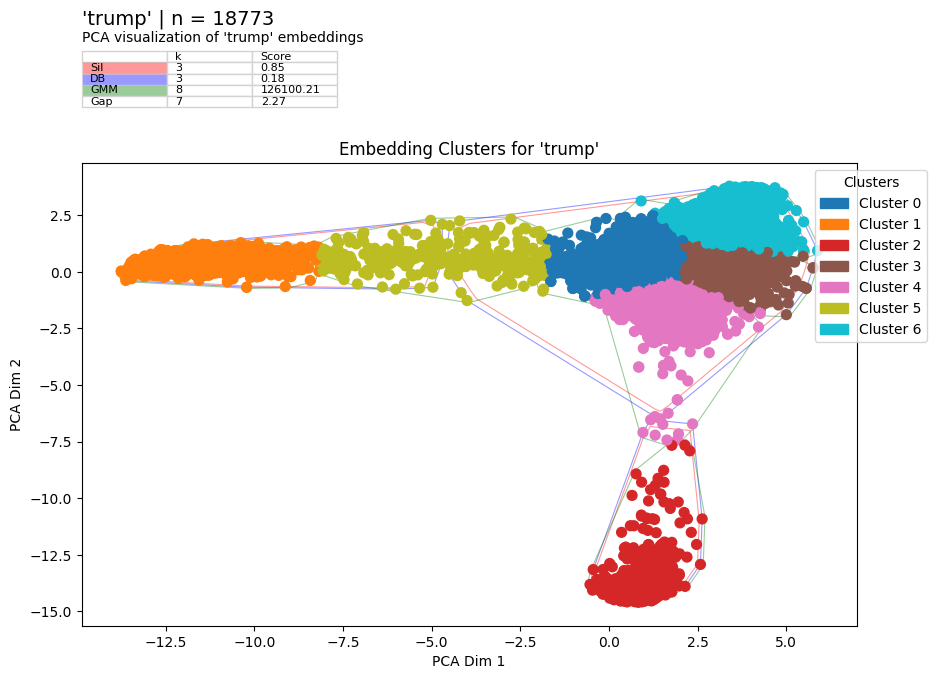

/var/folders/87/9qwg67f164gck_jk0qq9fkc40000gn/T/ipykernel_69921/3779674930.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[metric] = labels
/var/folders/87/9qwg67f164gck_jk0qq9fkc40000gn/T/ipykernel_69921/3779674930.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[metric] = labels
/var/folders/87/9qwg67f164gck_jk0qq9fkc40000gn/T/ipykernel_69921/3779674930.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,index,Post ID,Text,ParentWord,embeddings,gap_cluster,silhouette_cluster,davies_bouldin_cluster,gmm_cluster
9986,413269,464053053,lets compare the current state of biden and tr...,trump,"[-0.38597712, 0.33518583, 0.018573804, 0.30240...",0,0,0,0
9987,413270,464053343,hey trump is raising $43m in one night tomorro...,trump,"[0.26231015, 0.76651627, 1.1577938, -0.1915852...",0,0,0,0
9988,413271,464053500,biden has so far raised waaaaaay more. and mos...,trump,"[-1.1688713, 0.3040659, -0.1500475, -0.1131718...",3,0,0,3
9989,413272,464053794,trump currently miisn't the michigan gop com...,trump,"[-0.47161782, -0.15188694, -0.1363964, -0.1125...",1,1,1,1
9990,413273,464054004,cope cope copei am imagining in my head what w...,trump,"[-0.46356001, 0.31558445, 0.905455, -0.7811674...",4,0,0,0
...,...,...,...,...,...,...,...,...,...
28756,433751,463728004,why did trump print ten trillion in april 2020...,trump,"[0.199277, -0.3968956, -0.071229786, 0.0011607...",3,0,0,3
28757,433752,463728420,"trump didn't print. the fed, which is a public...",trump,"[-0.014142618, 0.15267745, 0.060621742, 0.2036...",1,1,1,1
28758,433753,463728524,trump is weak and pathetic and didnt du nuffin...,trump,"[-0.29095745, 0.21863094, 0.09822012, 0.129565...",1,1,1,1
28759,433754,463735378,guess who is winning in november? not trump. r...,trump,"[-0.045049768, -0.05071223, 0.7673158, -0.2546...",0,0,0,7


In [95]:
process_embeddings(trumpa, 'trump')

In [ ]:
bootycheeks = process_embeddings(trumpa, 'trump')

In [127]:
theids = list(zip((tump['Replied To']), (tump['Post ID'])))

In [134]:
tumpembed = {
    str(row['Post ID']): {col: row[col] for col in bootycheeks.columns if col != 'Post ID'}
    for _, row in bootycheeks.iterrows()
}


In [130]:
theids = [(str(a), str(b)) for a, b in theids]

In [ ]:
methods = ['gap_cluster', 'silhouette_cluster', 'davies_bouldin_cluster', 'gmm_cluster']
data = {method: [] for method in methods}
missing_keys = set()  # To track all missing keys

for parent, child in theids:
    for method in methods:
        try:
            parent_cluster = tumpembed[parent][method]
            child_cluster = tumpembed[child][method]
            data[method].append((parent_cluster, child_cluster))
        except KeyError as e:
            missing_keys.add(str(e.args[0]))  # Add the missing key to the set
if missing_keys:
    print("Missing keys:", ", ".join(missing_keys))

Missing keys: 479833925, 462205694, 477813807, 474059501, 479157087, 475193095, 475023557, 471640911, 460674992, 475316317, 479333044, 475601047, 471057192, 475818676, 470422353, 475088155, 470371429, 468557585, 479740787, 475637185, 455790851, 476457547, 475478039, 468124512, 430446190, 483920371, 474377276, 475120525, 475527311, 456294963, 482787240, 447789450, 477103163, 474243111, 476517148, 436710025, 474079457, 481253461, 474578363, 476437912, 470530930, 475563795, 475103630, 476697297, 475812123, 474953924, 455318263, 481388841, 474203682, 466939345, 475402768, 469420863, 476656761, 476215311, 469560265, 476742404, 474849855, 479321909, 480350167, 483233973, 477730955, 433418934, 474808507, 483348967, 483505314, 458249699, 465739351, 460939674, 467986002, 475458265, 474668962, 476507916, 399188109, 419550295, 478336028, 474838224, 469112629, 475182779, 483059996, 463077018, 478929084, 477441811, 478160817, 474553116, 476545580, 457735251, 475792480, 474420840, 473576472, 4778627

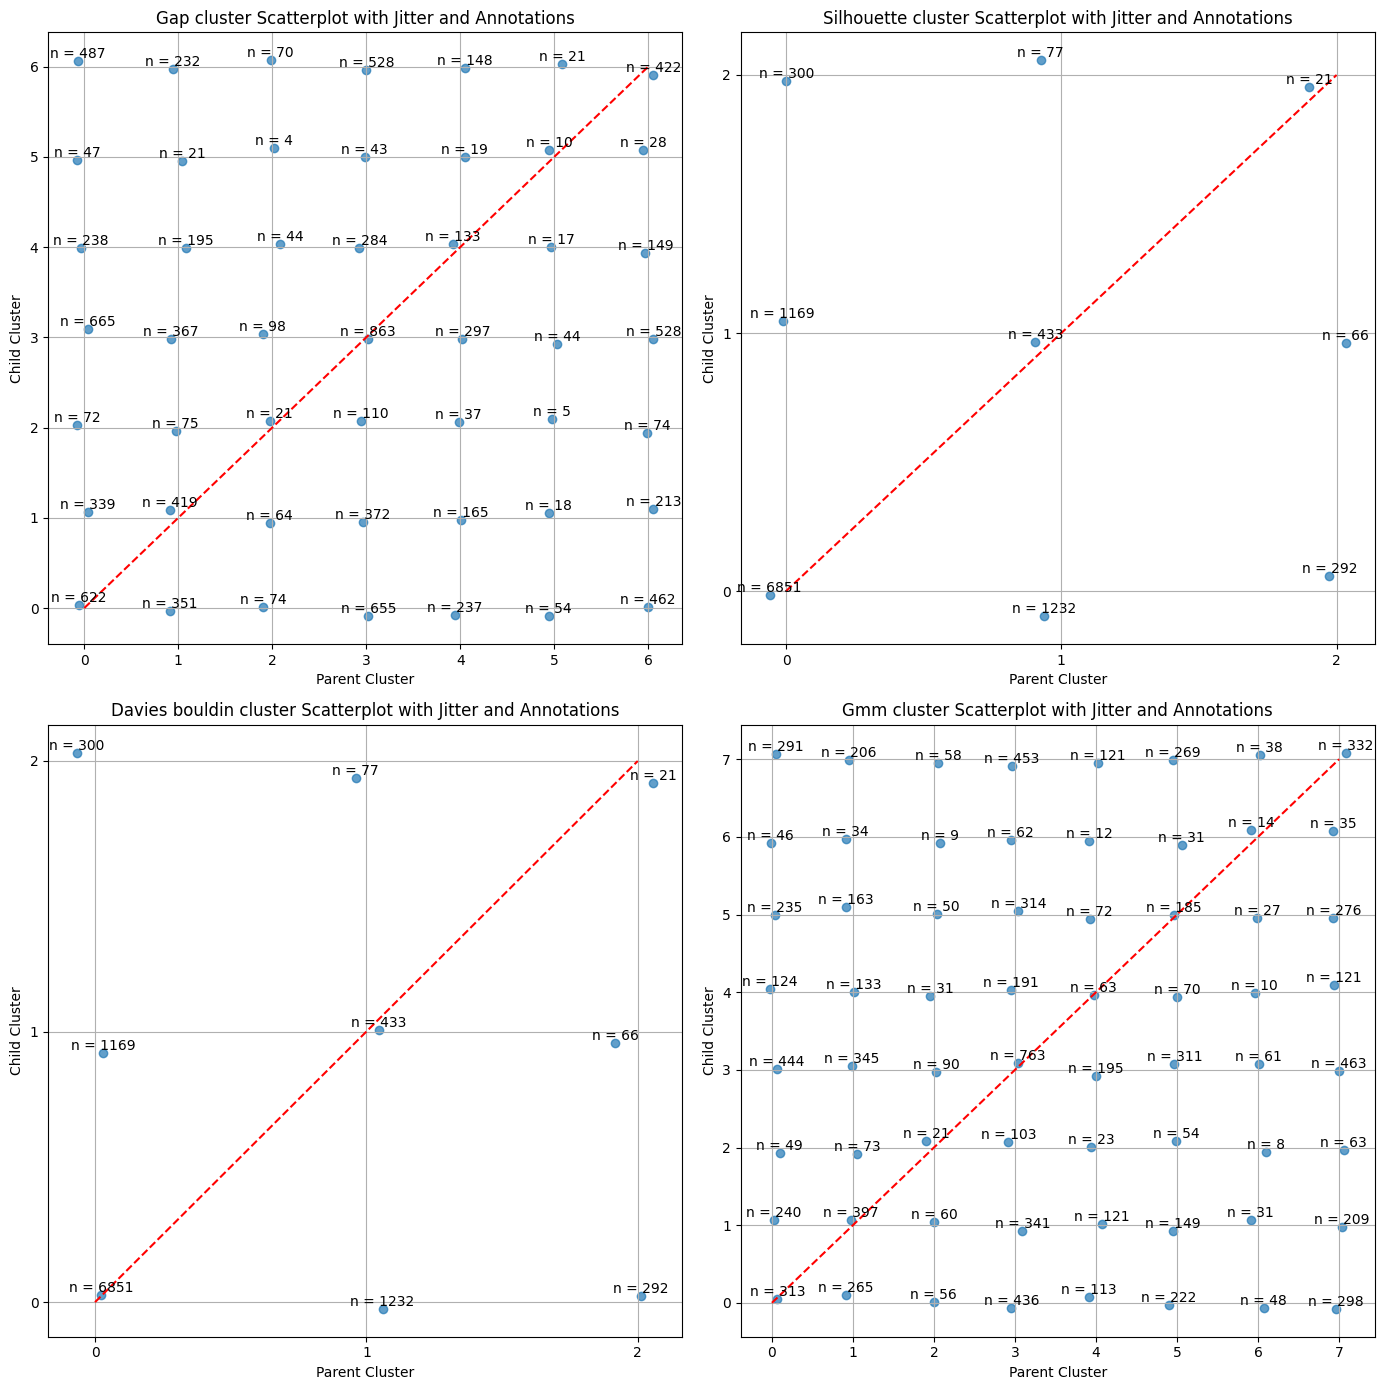

In [156]:
plt.figure(figsize=(14, 14))
for i, method in enumerate(methods, 1):
    plt.subplot(2, 2, i)
    parent_child_pairs = data[method]
    counts = Counter(parent_child_pairs)
    x, y = zip(*counts.keys())
    jitter = 0.1
    x_jittered = [val + np.random.uniform(-jitter, jitter) for val in x]
    y_jittered = [val + np.random.uniform(-jitter, jitter) for val in y]
    plt.scatter(x_jittered, y_jittered, alpha=0.7)
    plt.plot([min(x), max(x)], [min(x), max(x)], color='red', linestyle='--')
    for j, count in enumerate(counts.values()):
        plt.text(x_jittered[j], y_jittered[j], f'n = {count}', fontsize=10, ha='center', va='bottom')
    plt.xticks(range(min(x), max(x) + 1))
    plt.yticks(range(min(y), max(y) + 1))
    plt.title(f"{method.replace('_', ' ').capitalize()} Scatterplot with Jitter and Annotations")
    plt.xlabel("Parent Cluster")
    plt.ylabel("Child Cluster")
    plt.grid(True)

plt.tight_layout()
plt.show()


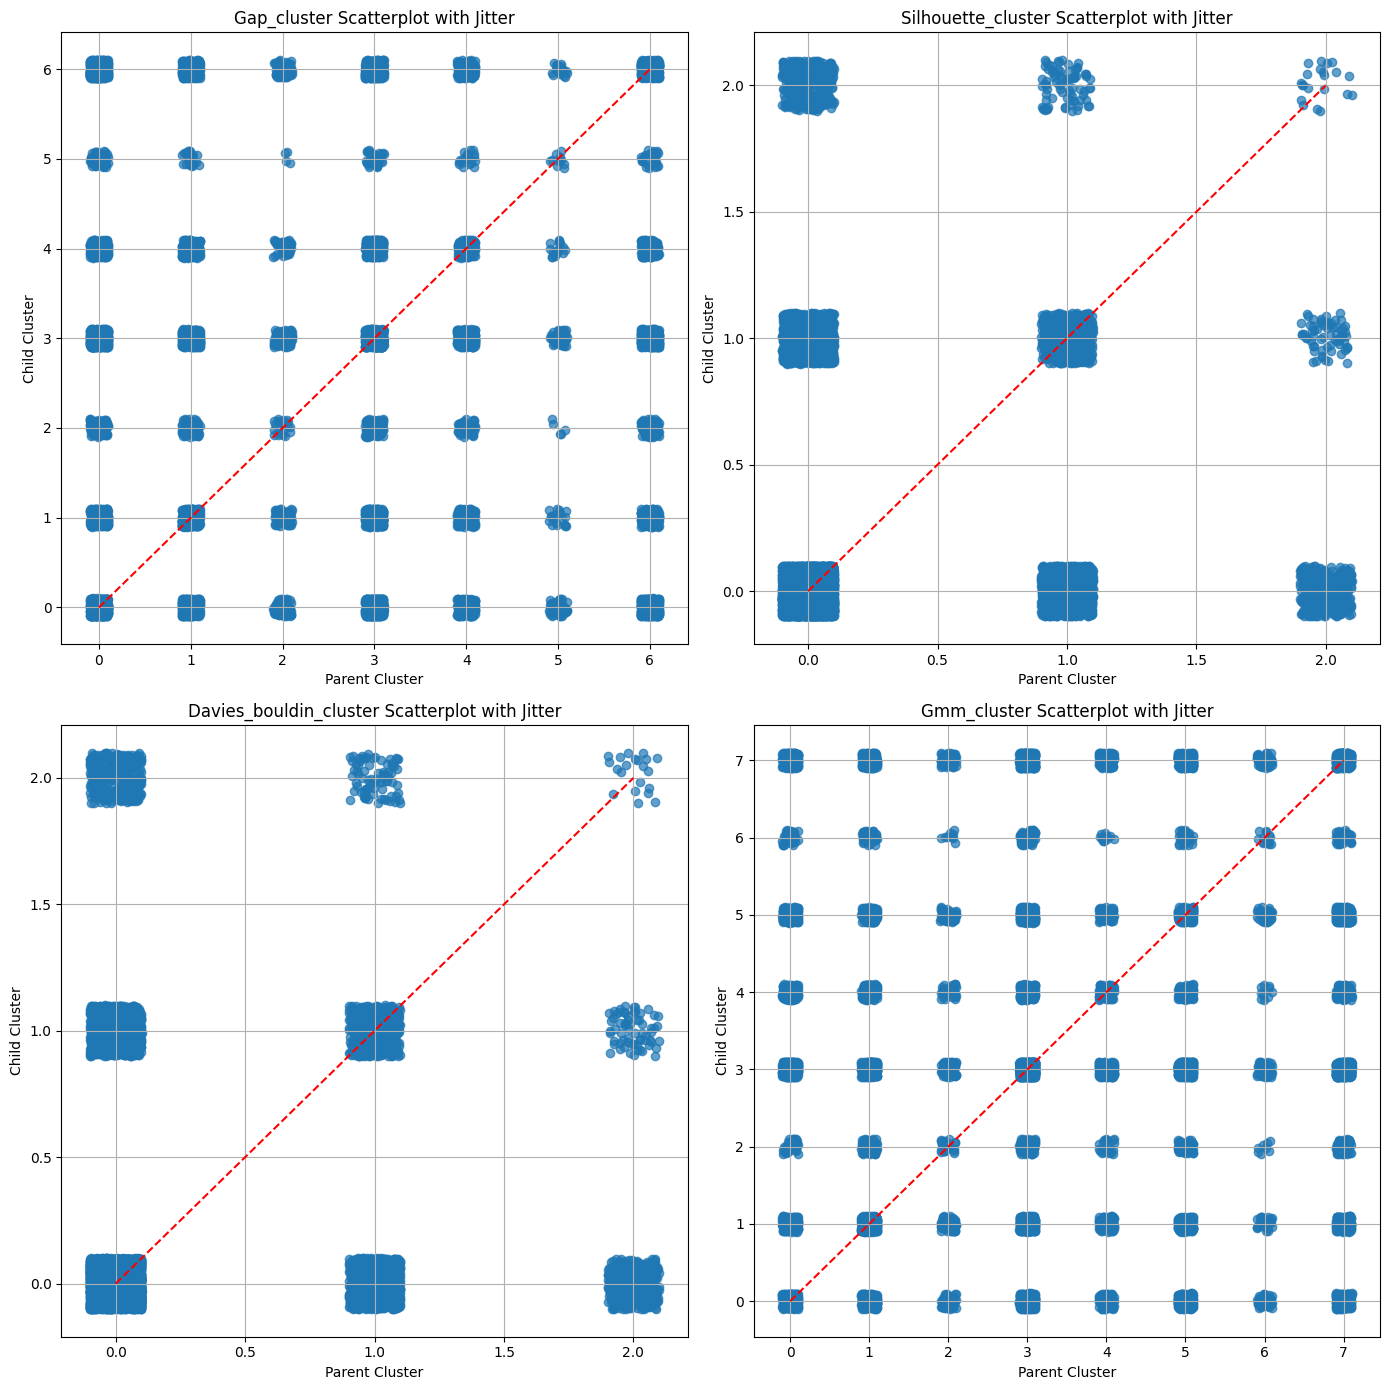

In [ ]:
plt.figure(figsize=(14, 14))
for i, method in enumerate(methods, 1):
    plt.subplot(2, 2, i)
    parent_child_pairs = data[method]
    x, y = zip(*parent_child_pairs)
    
    # Add jittering
    jitter = 0.1  # Adjust for more/less separation
    x_jittered = [val + np.random.uniform(-jitter, jitter) for val in x]
    y_jittered = [val + np.random.uniform(-jitter, jitter) for val in y]
    
    # Plot points
    plt.scatter(x_jittered, y_jittered, alpha=0.7)
    plt.plot([min(x), max(x)], [min(x), max(x)], color='red', linestyle='--')  # y = x line
    plt.title(f"{method.capitalize()} Scatterplot with Jitter")
    plt.xlabel("Parent Cluster")
    plt.ylabel("Child Cluster")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [166]:
tump

,Parent Text,Text,Replied To,Post ID,ParentDepend,ParentType,TextDepend,TextType,ParentWord,TextWord,ParentCoarsePOS,TextCoarsePOS,ParentFinePOS,TextFinePOS,CoarseTransition,FineTransition
413269,hey trump is raising $43m in one night tomorro...,lets compare the current state of biden and tr...,464053343,464053053,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",nsubj,"{'word': 'trump', 'coarse_pos': 'VERB', 'fine_...",conj,trump,trump,NOUN,VERB,NN,VB,NOUN→VERB,NN→VB
413270,biden has so far raised waaaaaay more. and mos...,hey trump is raising $43m in one night tomorro...,464053500,464053343,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",poss,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",nsubj,trump,trump,NOUN,NOUN,NN,NN,NOUN→NOUN,NN→NN
413271,cope cope cope>t-t-t-trump can't raise money>t...,biden has so far raised waaaaaay more. and mos...,464053609,464053500,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",npadvmod,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",poss,trump,trump,NOUN,NOUN,NN,NN,NOUN→NOUN,NN→NN
413272,lets compare the current state of biden and tr...,trump currently miisn't the michigan gop com...,464053053,464053794,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",compound,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",ROOT,trump,trump,NOUN,NOUN,NN,NN,NOUN→NOUN,NN→NN
413273,i'm upset trump is losing>the rnc just put up ...,cope cope copei am imagining in my head what w...,464054173,464054004,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",nsubj,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",nsubj,trump,trump,NOUN,NOUN,NN,NN,NOUN→NOUN,NN→NN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433751,"trump didn't print. the fed, which is a public...",why did trump print ten trillion in april 2020...,463728420,463728004,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",nsubj,"{'word': 'trump', 'coarse_pos': 'VERB', 'fine_...",csubj,trump,trump,NOUN,VERB,NN,VB,NOUN→VERB,NN→VB
433752,>trump is weak and pathetic and didnt du nuffi...,"trump didn't print. the fed, which is a public...",463728524,463728420,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",nsubj,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",nsubj,trump,trump,NOUN,NOUN,NN,NN,NOUN→NOUN,NN→NN
433753,i look at the world how it is. if trump was we...,trump is weak and pathetic and didnt du nuffin...,463728752,463728524,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",nsubj,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",nsubj,trump,trump,NOUN,NOUN,NN,NN,NOUN→NOUN,NN→NN
433754,yeprightwingers will do anything to keep trump...,guess who is winning in november? not trump. r...,463735572,463735378,"{'word': 'trump', 'coarse_pos': 'NOUN', 'fine_...",xcomp,"{'word': 'trump', 'coarse_pos': 'VERB', 'fine_...",ROOT,trump,trump,NOUN,VERB,NN,VB,NOUN→VERB,NN→VB


In [167]:
ouch = [
    {(row['Replied To'], row['Post ID']): (row['ParentCoarsePOS'], row['TextCoarsePOS'])}
    for _, row in tump.iterrows()
]

In [168]:
ouch

[{(464053343, 464053053): ('NOUN', 'VERB')},
 {(464053500, 464053343): ('NOUN', 'NOUN')},
 {(464053609, 464053500): ('NOUN', 'NOUN')},
 {(464053053, 464053794): ('NOUN', 'NOUN')},
 {(464054173, 464054004): ('NOUN', 'NOUN')},
 {(464054173, 464054395): ('NOUN', 'NOUN')},
 {(464065699, 464065476): ('NOUN', 'NOUN')},
 {(464065476, 464065699): ('NOUN', 'NOUN')},
 {(464639765, 464639634): ('VERB', 'NOUN')},
 {(464697516, 464697304): ('VERB', 'PROPN')},
 {(464697304, 464697516): ('PROPN', 'VERB')},
 {(464756612, 464756515): ('NOUN', 'ADJ')},
 {(464756515, 464756612): ('ADJ', 'NOUN')},
 {(464986406, 464986183): ('NOUN', 'NOUN')},
 {(464986183, 464986406): ('NOUN', 'NOUN')},
 {(465040613, 465033032): ('NOUN', 'NOUN')},
 {(465040745, 465040613): ('NOUN', 'NOUN')},
 {(465040613, 465040745): ('NOUN', 'NOUN')},
 {(465664798, 465664609): ('NOUN', 'NOUN')},
 {(465691441, 465692020): ('NOUN', 'VERB')},
 {(465694586, 465687771): ('NOUN', 'NOUN')},
 {(465681693, 465688474): ('NOUN', 'NOUN')},
 {(4656939

In [ ]:
methods = ['gap_cluster', 'silhouette_cluster', 'davies_bouldin_cluster', 'gmm_cluster']
results = {method: [] for method in methods}
missing_keys = set()  # To track all missing keys
for parent, child in theids:
    for method in methods:
        try:
            parent_cluster = tumpembed[str(parent)][method]
            child_cluster = tumpembed[str(child)][method]
            results[method].append({(parent, child): (parent_cluster, child_cluster)})
        except KeyError as e:
            missing_keys.add(str(e.args[0]))  # Add the missing key to the set
if missing_keys:
    print("Missing keys:", ", ".join(missing_keys))

results

Missing keys: 479833925, 462205694, 477813807, 474059501, 479157087, 475193095, 475023557, 471640911, 460674992, 475316317, 479333044, 475601047, 471057192, 475818676, 470422353, 475088155, 470371429, 468557585, 479740787, 475637185, 455790851, 476457547, 475478039, 468124512, 430446190, 483920371, 474377276, 475120525, 475527311, 456294963, 482787240, 447789450, 477103163, 474243111, 476517148, 436710025, 474079457, 481253461, 474578363, 476437912, 470530930, 475563795, 475103630, 476697297, 475812123, 474953924, 455318263, 481388841, 474203682, 466939345, 475402768, 469420863, 476656761, 476215311, 469560265, 476742404, 474849855, 479321909, 480350167, 483233973, 477730955, 433418934, 474808507, 483348967, 483505314, 458249699, 465739351, 460939674, 467986002, 475458265, 474668962, 476507916, 399188109, 419550295, 478336028, 474838224, 469112629, 475182779, 483059996, 463077018, 478929084, 477441811, 478160817, 474553116, 476545580, 457735251, 475792480, 474420840, 473576472, 4778627

{'gap_cluster': [{('464053343', '464053053'): (0, 0)},
  {('464053500', '464053343'): (3, 0)},
  {('464053053', '464053794'): (0, 1)},
  {('464065699', '464065476'): (6, 4)},
  {('464065476', '464065699'): (4, 6)},
  {('464697516', '464697304'): (4, 0)},
  {('464697304', '464697516'): (0, 4)},
  {('464756612', '464756515'): (0, 3)},
  {('464756515', '464756612'): (3, 0)},
  {('464986406', '464986183'): (1, 6)},
  {('464986183', '464986406'): (6, 1)},
  {('465040613', '465033032'): (1, 1)},
  {('465040745', '465040613'): (3, 1)},
  {('465040613', '465040745'): (1, 3)},
  {('465693924', '465693046'): (0, 1)},
  {('465693046', '465693924'): (1, 0)},
  {('465695986', '465695686'): (3, 0)},
  {('465695686', '465695986'): (0, 3)},
  {('466367877', '466364732'): (0, 6)},
  {('466373387', '466367877'): (3, 0)},
  {('466371928', '466371544'): (3, 2)},
  {('466372347', '466371928'): (3, 3)},
  {('466371928', '466372347'): (3, 3)},
  {('466367877', '466373387'): (0, 3)},
  {('466376992', '4663762

In [171]:
rows = {}
for method, pairs in results.items():
    for pair_dict in pairs:
        for key, value in pair_dict.items():
            flattened_key = f"{key[0]}_{key[1]}"
            if flattened_key not in rows:
                rows[flattened_key] = {}
            rows[flattened_key][method] = value

gg = pd.DataFrame.from_dict(rows, orient='index').reset_index()
gg.columns = ['Pair', 'gap_cluster', 'silhouette_cluster', 'davies_bouldin_cluster', 'gmm_cluster']


In [172]:
gg

,Pair,gap_cluster,silhouette_cluster,davies_bouldin_cluster,gmm_cluster
0,464053343_464053053,"(0, 0)","(0, 0)","(0, 0)","(0, 0)"
1,464053500_464053343,"(3, 0)","(0, 0)","(0, 0)","(3, 0)"
2,464053053_464053794,"(0, 1)","(0, 1)","(0, 1)","(0, 1)"
3,464065699_464065476,"(6, 4)","(0, 0)","(0, 0)","(7, 4)"
4,464065476_464065699,"(4, 6)","(0, 0)","(0, 0)","(4, 7)"
...,...,...,...,...,...
9705,462311332_462311375,"(0, 0)","(0, 0)","(0, 0)","(0, 0)"
9706,463728420_463728004,"(1, 3)","(1, 0)","(1, 0)","(1, 3)"
9707,463728524_463728420,"(1, 1)","(1, 1)","(1, 1)","(1, 1)"
9708,463735572_463735378,"(6, 0)","(0, 0)","(0, 0)","(5, 7)"


In [176]:
# Convert ouch list to a dictionary
ouch_dict = {key: value for d in ouch for key, value in d.items()}

# Add the 'POS' column by matching with the 'ouch_dict'
gg['POS'] = gg['Pair'].apply(lambda pair: ouch_dict.get(tuple(map(int, pair.split('_'))), ('UNKNOWN', 'UNKNOWN')))


In [185]:
gg

,Pair,gap_cluster,silhouette_cluster,davies_bouldin_cluster,gmm_cluster,POS,Disagreement,Total_Agreement,Total_Disagreement,Partial_Agreement,Agreement,Full_Agreement
0,464053343_464053053,"(0, 0)","(0, 0)","(0, 0)","(0, 0)","(NOUN, VERB)",True,False,True,False,False,False
1,464053500_464053343,"(3, 0)","(0, 0)","(0, 0)","(3, 0)","(NOUN, NOUN)",True,False,True,False,False,False
2,464053053_464053794,"(0, 1)","(0, 1)","(0, 1)","(0, 1)","(NOUN, NOUN)",True,False,True,False,False,False
3,464065699_464065476,"(6, 4)","(0, 0)","(0, 0)","(7, 4)","(NOUN, NOUN)",True,False,True,False,False,False
4,464065476_464065699,"(4, 6)","(0, 0)","(0, 0)","(4, 7)","(NOUN, NOUN)",True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9705,462311332_462311375,"(0, 0)","(0, 0)","(0, 0)","(0, 0)","(NOUN, NOUN)",True,False,True,False,False,False
9706,463728420_463728004,"(1, 3)","(1, 0)","(1, 0)","(1, 3)","(NOUN, VERB)",True,False,True,False,False,False
9707,463728524_463728420,"(1, 1)","(1, 1)","(1, 1)","(1, 1)","(NOUN, NOUN)",True,False,True,False,False,False
9708,463735572_463735378,"(6, 0)","(0, 0)","(0, 0)","(5, 7)","(NOUN, VERB)",True,False,True,False,False,False


In [186]:
def is_agreement(value):
    # Check if all columns are tuples and agree
    if isinstance(value, tuple):
        return value[0] == value[1]
    return False

def all_agree(row):
    # Ensure all values across columns agree
    return all(is_agreement(value) for value in row[1:])  # Exclude 'Pair' column

def any_disagree(row):
    # Ensure disagreement only if any value disagrees
    return any(not is_agreement(value) for value in row[1:])

gg["Full_Agreement"] = gg.apply(all_agree, axis=1)
gg["Total_Disagreement"] = gg.apply(any_disagree, axis=1) & (~gg["Full_Agreement"])
gg["Partial_Agreement"] = (~gg["Full_Agreement"]) & (~gg["Total_Disagreement"])
gg

,Pair,gap_cluster,silhouette_cluster,davies_bouldin_cluster,gmm_cluster,POS,Disagreement,Total_Agreement,Total_Disagreement,Partial_Agreement,Agreement,Full_Agreement
0,464053343_464053053,"(0, 0)","(0, 0)","(0, 0)","(0, 0)","(NOUN, VERB)",True,False,True,False,False,False
1,464053500_464053343,"(3, 0)","(0, 0)","(0, 0)","(3, 0)","(NOUN, NOUN)",True,False,True,False,False,False
2,464053053_464053794,"(0, 1)","(0, 1)","(0, 1)","(0, 1)","(NOUN, NOUN)",True,False,True,False,False,False
3,464065699_464065476,"(6, 4)","(0, 0)","(0, 0)","(7, 4)","(NOUN, NOUN)",True,False,True,False,False,False
4,464065476_464065699,"(4, 6)","(0, 0)","(0, 0)","(4, 7)","(NOUN, NOUN)",True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9705,462311332_462311375,"(0, 0)","(0, 0)","(0, 0)","(0, 0)","(NOUN, NOUN)",True,False,True,False,False,False
9706,463728420_463728004,"(1, 3)","(1, 0)","(1, 0)","(1, 3)","(NOUN, VERB)",True,False,True,False,False,False
9707,463728524_463728420,"(1, 1)","(1, 1)","(1, 1)","(1, 1)","(NOUN, NOUN)",True,False,True,False,False,False
9708,463735572_463735378,"(6, 0)","(0, 0)","(0, 0)","(5, 7)","(NOUN, VERB)",True,False,True,False,False,False


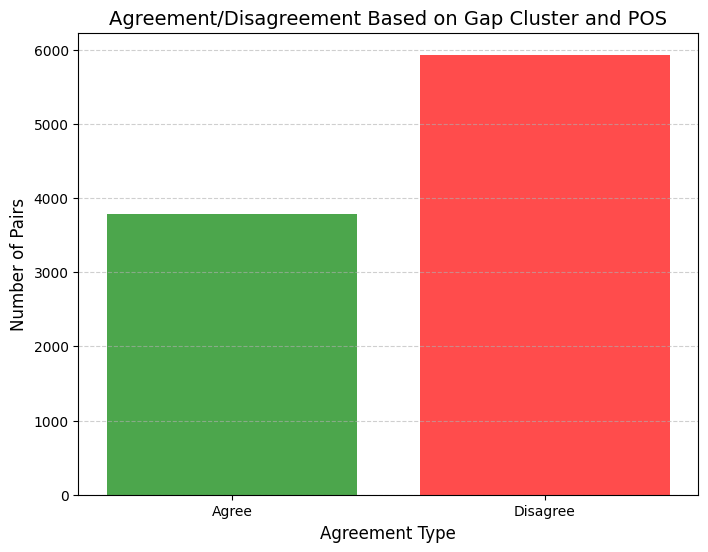

In [187]:
def check_agreement(row):
    gap = row["gap_cluster"]
    pos = row["POS"]
    gap_agrees = gap[0] == gap[1]
    pos_agrees = pos[0] == pos[1]
    return (gap_agrees and pos_agrees) or (not gap_agrees and not pos_agrees)

gg["Agreement"] = gg.apply(check_agreement, axis=1)
gg["Disagreement"] = ~gg["Agreement"]

agreement_counts = gg[["Agreement", "Disagreement"]].sum()
agreement_counts.index = ["Agree", "Disagree"]

plt.figure(figsize=(8, 6))
plt.bar(agreement_counts.index, agreement_counts.values, color=["green", "red"], alpha=0.7)
plt.title("Agreement/Disagreement Based on Gap Cluster and POS", fontsize=14)
plt.ylabel("Number of Pairs", fontsize=12)
plt.xlabel("Agreement Type", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


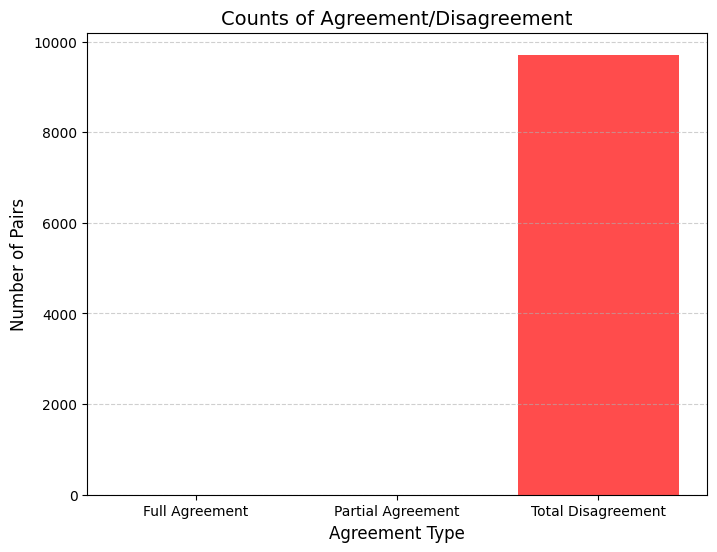

In [184]:
def is_agreement(value):
    # Check if the tuple is in the form (x, x)
    return isinstance(value, tuple) and value[0] == value[1]

def all_agree(row):
    # Check if all columns agree (all tuples are in the form (x, x))
    return all(is_agreement(value) for value in row)

def any_disagree(row):
    # Check if any column disagrees (any tuple is not in the form (x, x))
    return any(not is_agreement(value) for value in row)

# Apply the logic to the dataframe
gg["Full_Agreement"] = gg.apply(all_agree, axis=1)
gg["Total_Disagreement"] = gg.apply(any_disagree, axis=1) & (~gg["Full_Agreement"])
gg["Partial_Agreement"] = (~gg["Full_Agreement"]) & (~gg["Total_Disagreement"])

# Count each category
agreement_counts = gg[["Full_Agreement", "Partial_Agreement", "Total_Disagreement"]].sum()
agreement_counts.index = ["Full Agreement", "Partial Agreement", "Total Disagreement"]

# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(agreement_counts.index, agreement_counts.values, color=["green", "blue", "red"], alpha=0.7)
plt.title("Counts of Agreement/Disagreement", fontsize=14)
plt.ylabel("Number of Pairs", fontsize=12)
plt.xlabel("Agreement Type", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()




In [26]:
# Top N most entropic words
top_n = word_entropy.nlargest(10, 'Entropy')

# Words with entropy above a threshold
threshold = 1.0
high_entropy = word_entropy[word_entropy['Entropy'] > threshold]

# Words in the top 10% of entropy
percentile_90 = word_entropy['Entropy'].quantile(0.9)
top_10_percent = word_entropy[word_entropy['Entropy'] > percentile_90]

# Words with entropy in the top quartile
q3 = word_entropy['Entropy'].quantile(0.75)
top_quartile = word_entropy[word_entropy['Entropy'] > q3]

# Words flagged as outliers using IQR
q1 = word_entropy['Entropy'].quantile(0.25)
iqr = q3 - q1
iqr_outliers = word_entropy[word_entropy['Entropy'] > (q3 + 1.5 * iqr)]

# Words with Z-score > 2
mean_entropy = word_entropy['Entropy'].mean()
std_entropy = word_entropy['Entropy'].std()
word_entropy['Z-Score'] = (word_entropy['Entropy'] - mean_entropy) / std_entropy
high_zscore = word_entropy[word_entropy['Z-Score'] > 2]


In [27]:
high_zscore

,ParentWord,Entropy,Z-Score
29,fuck,1.723944,2.281998
65,nigger,2.234251,3.192506
71,post,1.829479,2.470297
78,right,2.247736,3.216566


In [64]:
word_entropy.to_csv("top13entropy.csv")

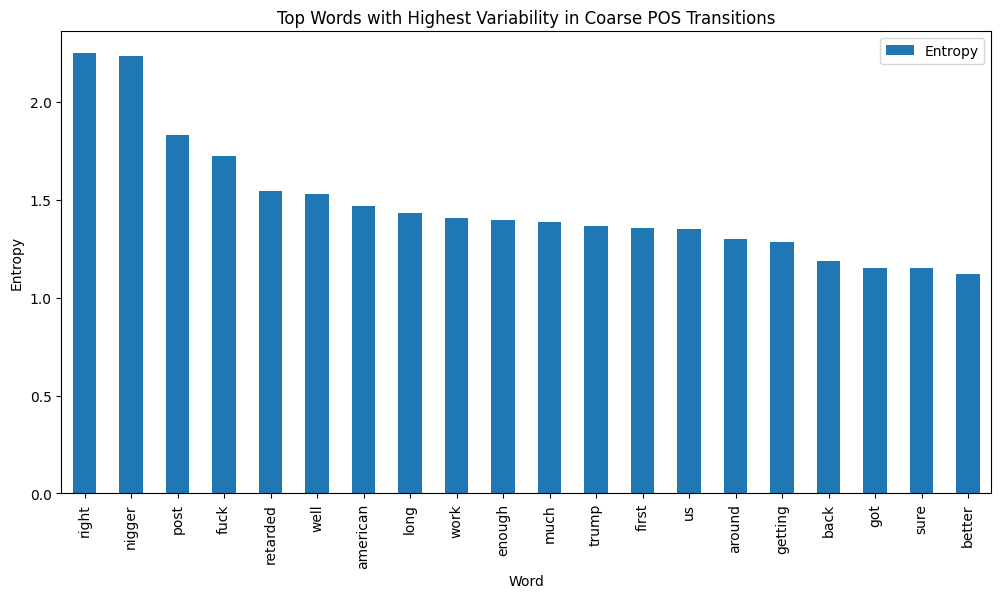

In [ ]:
word_entropy.sort_values(by='Entropy', ascending=False).head(20).plot(
    x='ParentWord', y='Entropy', kind='bar', figsize=(12, 6))
plt.title('Top Words with Highest Variability in Coarse POS Transitions')
plt.ylabel('Entropy')
plt.xlabel('Word')
plt.show()


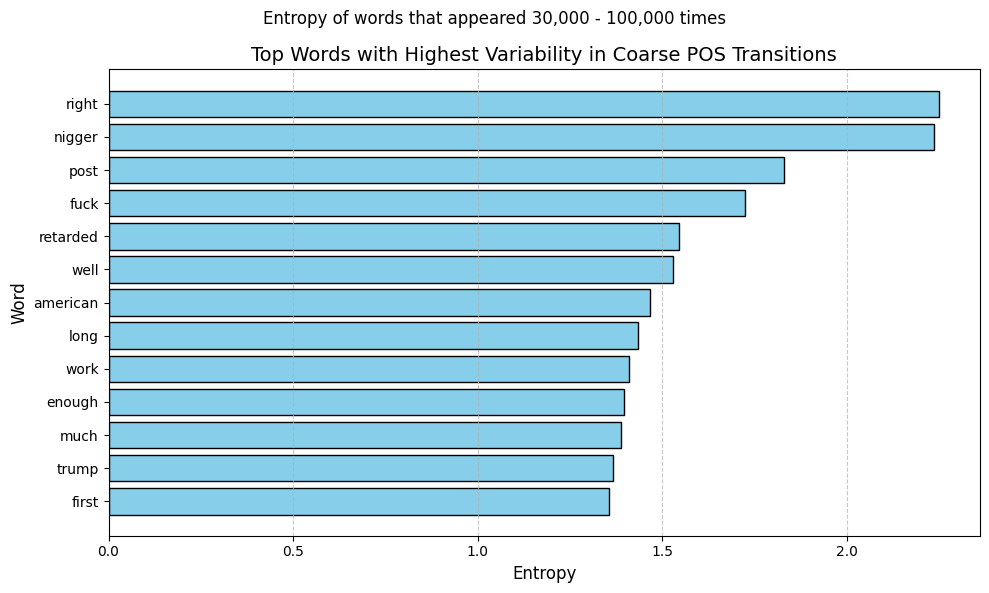

In [ ]:
# Sort by entropy and limit to the top 13 words
top_words = word_entropy.sort_values(by='Entropy', ascending=False).head(13)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_words['ParentWord'], top_words['Entropy'], color='skyblue', edgecolor='black')
plt.title('Top Words with Highest Variability in Coarse POS Transitions', fontsize=14)
plt.suptitle("Entropy of words that appeared 30,000 - 100,000 times", fontsize=12)
plt.xlabel('Entropy', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


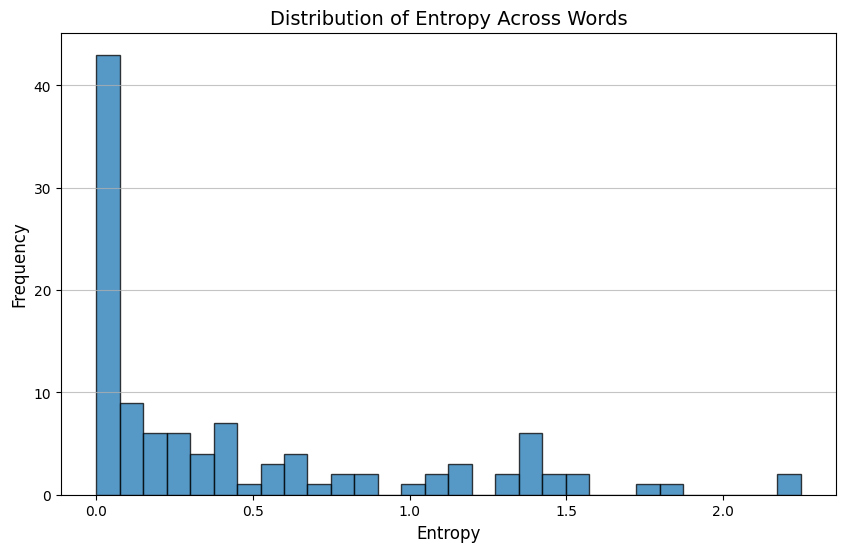

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(word_entropy['Entropy'], bins=30, alpha=0.75, edgecolor='black')
plt.title('Distribution of Entropy Across Words', fontsize=14)
plt.xlabel('Entropy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()
